In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from math import *
import csv
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from pandas import concat
from pandas import DataFrame

from math import sqrt
from numpy import concatenate


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [2]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [3]:
dataPath = "project\data\ME_data_new.csv"
data = pd.read_csv(dataPath)
data=data.iloc[:,2:6]
data=data.drop(columns=["WindDirection"])
# encoder1 = LabelEncoder()
# values1=data.iloc[:,2]
# values1 = encoder1.fit_transform(values1)
# # values1 = encoder1.inverse_transform(values1)
# # encoder2 = LabelEncoder()
# # values2=data.iloc[:,4]
# # values2 = encoder2.fit_transform(values2)
# # values2 = encoder2.inverse_transform(values2)
# data['WindDirection']=values1
# # data['Weather']=values2
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(data)
reframed = series_to_supervised(scaled, 1, 1)
reframed

FileNotFoundError: [Errno 2] No such file or directory: 'project\\data\\ME_data_new.csv'

In [ ]:
values = reframed.values
n_train_hours = 365*5
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-3], train[:, -3:]  
test_X, test_y = test[:, :-3], test[:, -3:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1825, 1, 3) (1825, 3) (972, 1, 3) (972, 3)


Epoch 1/50
37/37 - 3s - loss: 0.3103 - val_loss: 0.2239 - 3s/epoch - 78ms/step
Epoch 2/50
37/37 - 0s - loss: 0.1661 - val_loss: 0.1095 - 162ms/epoch - 4ms/step
Epoch 3/50
37/37 - 0s - loss: 0.1067 - val_loss: 0.0988 - 161ms/epoch - 4ms/step
Epoch 4/50
37/37 - 0s - loss: 0.0993 - val_loss: 0.0923 - 155ms/epoch - 4ms/step
Epoch 5/50
37/37 - 0s - loss: 0.0927 - val_loss: 0.0867 - 152ms/epoch - 4ms/step
Epoch 6/50
37/37 - 0s - loss: 0.0862 - val_loss: 0.0813 - 156ms/epoch - 4ms/step
Epoch 7/50
37/37 - 0s - loss: 0.0802 - val_loss: 0.0765 - 160ms/epoch - 4ms/step
Epoch 8/50
37/37 - 0s - loss: 0.0753 - val_loss: 0.0732 - 156ms/epoch - 4ms/step
Epoch 9/50
37/37 - 0s - loss: 0.0720 - val_loss: 0.0718 - 199ms/epoch - 5ms/step
Epoch 10/50
37/37 - 0s - loss: 0.0704 - val_loss: 0.0712 - 160ms/epoch - 4ms/step
Epoch 11/50
37/37 - 0s - loss: 0.0698 - val_loss: 0.0709 - 149ms/epoch - 4ms/step
Epoch 12/50
37/37 - 0s - loss: 0.0697 - val_loss: 0.0707 - 146ms/epoch - 4ms/step
Epoch 13/50
37/37 - 0s - lo

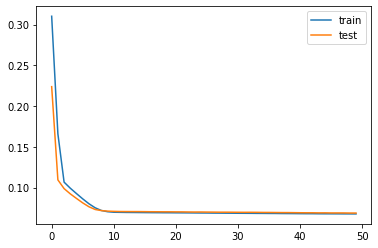

Test RMSE: 16.396


array([[ 6.9060802,  2.960184 ,  1.7360846],
       [ 7.545146 ,  4.128962 ,  1.6859936],
       [ 9.257312 ,  5.6121664,  1.2302024],
       ...,
       [21.436058 , 17.144722 ,  1.6439989],
       [22.982754 , 17.725645 ,  1.5409348],
       [30.713839 , 22.261267 ,  1.5129097]], dtype=float32)

In [ ]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(3))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=50, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
yhat = scaler.inverse_transform(yhat)
# calculate RMSE
rmse = sqrt(mean_squared_error(test_X, yhat))
print('Test RMSE: %.3f' % rmse)
yhat

In [ ]:
# PridictData=pd.DataFrame(yhat.astype('int64'))
# values3=PridictData.iloc[:,2]
# values3 = encoder1.inverse_transform(values3)
# # values4=PridictData.iloc[:,4]
# # values4 = encoder2.inverse_transform(values4)
# print(values3)